# Watershed Delineation using PCRaster
**Project Area: Ciliwung River Basin / DAS Ciliwung, Indonesia**

In this project, we will do a watershed delineation using PCRaster in Python. We will delineate the Ciliwung River Basin. Ciliwung River stretches from Jakarta Province to West Java (Jawa Barat) Province, Indonesia.

<center><img src="Images/location.png" width="800"/></center>

<div align="center"><i>The map above shows the approximate location of the Ciliwung River Basin / DAS Ciliwung (red square). Source: Author.</i></div>

First of all, we need to be in the location of our data folder. In this project, the DEM files are saved in a folder named 'DEMNAS'. We will import the `os` module and change the directory to the data folder.

In [1]:
#File path
import os
os.chdir("./DEMNAS") #change the directory to the data folder
print(os.getcwd()) #check the location/path

C:\Users\yoasl\Documents\Personal_Projects\Watershed_Delineation_using_Python\DEMNAS


Once we are in the correct directory, check the DEM files that we have. We will make a list of all GeoTIFF files in that folder to make sure all the data has been there. Use `glob` function from `glob` module to search a certain file extension.

In [2]:
#List of all GeoTIFF files
import glob

tifFiles = glob.glob("*.tif") #this searchs for file extentions
print(tifFiles)

['DEMNAS_1209-12_v1.0.tif', 'DEMNAS_1209-14_v1.0.tif', 'DEMNAS_1209-21_v1.0.tif', 'DEMNAS_1209-23_v1.0.tif', 'DEMNAS_1209-42_v1.0.tif', 'DEMNAS_1209-44_v1.0.tif', 'DEMNAS_1209-51_v1.0.tif', 'DEMNAS_1209-53_v1.0.tif']


We use DEM from DEMNAS, which is a national database created by the Indonesia Geospatial Information Agency (BIG) that provides Digital Elevation Model (DEM) and national bathymetry for Indonesia.

Next, we will create a virtual DEM from our TIFF files. We will merge all the files to become a mosaic. Use `BuildVRT` function from GDAL to create a virtual file. Then we need to use `FlushCache` method to save it to disk.

In [3]:
#Create a mosaic virtual file from GeoTIFF files using GDAL 
from osgeo import gdal
mosaic = gdal.BuildVRT("mosaic.vrt", tifFiles)
mosaic.FlushCache()

C:\Users\yoasl\mambaforge\envs\tutorials\Lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


0

After that, we will check the virtual DEM projection and transformation.

In [4]:
#Check projection and transformation of the virtual layer
ds = gdal.Open(r"mosaic.vrt")
print(ds.GetProjection())
print(ds.GetGeoTransform())


(106.75, 7.500750075007501e-05, 0.0, -6.0, 0.0, -7.500750075007501e-05)


From the output, we can see that the layer does not yet have projections. So we need to set the mosaic layer projection by reprojecting it. We reproject it to the default projection which is WGS 1984 / EPSG:4326. Use `gdal.Warp` function to reproject raster data.

In [5]:
#Reproject the virtual raster layer
dsReprj = gdal.Warp("demReprj.vrt", ds, dstSRS = "EPSG:4326")

Then we check the projection of the virtual layer again to assure that our reprojection has been successfull.

In [6]:
#Check virtual raster projection
print(dsReprj.GetProjection())

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]


Now the virtual layer has been projected to WGS 1984.

Next, we will reproject and clip the DEM mosaic. We clip it to our area of interest to shorten the data processing time. We reproject the mosaic (virtual) layer and the bounding box (shapefile) to the projection of the project area. In this case, we use EPSG:32748.

In [7]:
#Create a function to reproject and subset the DEM
def reprojectAndClip(inputraster, outputraster, projection, shapefile, resolution):
    options = gdal.WarpOptions(cutlineDSName=shapefile, cropToCutline=True, format="GTIFF", dstSRS=projection, xRes=resolution, yRes=resolution)
    outimage = gdal.Warp(srcDSOrSrcDSTab=inputraster, destNameOrDestDS=outputraster, options=options)

Mosaic = "demReprj.vrt"
Polygon = "bounding_box.shp"
EPSG = "EPSG:32748"
spatialResolution = 10
DEMSubset = "DEMsubset.tif"
reprojectAndClip(Mosaic, DEMSubset, EPSG, Polygon, spatialResolution)

Then we can plot the result using `pyplot` from matplotlib.

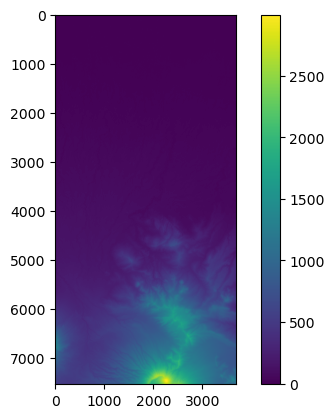

In [8]:
import matplotlib.pyplot as plt

dsDEMSubset = gdal.Open("DEMsubset.tif")
array = dsDEMSubset.GetRasterBand(1).ReadAsArray()
plt.imshow(array)
plt.colorbar()

Next step, we will convert the DEM subset which is a continuous raster to a PCRaster scalar map. We will use `gdal.Translate` to convert it.

In [9]:
from osgeo import gdalconst

def ConvertToPCRaster(src_filename, dst_filename, ot, VS):
    #Open existing dataset
    src_ds = gdal.Open(src_filename)

    #GDAL translate
    dst_ds = gdal.Translate(dst_filename, src_ds, format="PCRaster", outputType=ot, metadataOptions=VS)

    #Properly close the datasets to flush disk
    dst_ds = None
    src_ds = None

ConvertToPCRaster("DEMsubset.tif", "dem.map", gdalconst.GDT_Float32, "VS_SCALAR")

We can see the result using `aguila` from PCRaster.

In [10]:
from pcraster import *
DEM = readmap("dem.map")
aguila(DEM)

<center><img src="Images/aguila-dem.png"/></center>

<div align="center"><i>DEM Subset in PCRaster format is visualized with Aguila. Source: Author.</i></div>

After that, in order to delineate a catchment we need to know the flow direction. We will calculate the flow direction using `lddcreate` operation in PCRaster. This tool will fill the sink in the DEM, and result in a local drain direction (flow direction) map.

In [11]:
#Calculate Flow Direction

FlowDirection = lddcreate(DEM, 1e31, 1e31, 1e31, 1e31) #set the thresholds to a very high number
report(FlowDirection, "flowdir.map")
aguila(FlowDirection)

<center><img src="Images/aguila-flowdir.png"/></center>

<div align="center"><i>Flow Direction in PCRaster format is visualized with Aguila. Source: Author.</i></div>

If the filled DEM is needed, we can use the `lddcreatedem` tool. Create a DEM that is filled using `lddcreatedem` operation.

In [13]:
DEMFilled = lddcreatedem(DEM, 1e31, 1e31, 1e31, 1e31)

We can see the difference between DEM and the filled DEM by using map algebra.

In [14]:
#Calculate the difference between DEM and DEMFilled
Difference = DEMFilled - DEM
aguila(Difference)

<center><img src="Images/aguila-differencedem.png"/></center>

<div align="center"><i>We can see areas that are filled and how much they are filled. Source: Author.</i></div>

Next step we will delineate the streams. We will do it by using two different methods: Strahler order and Flow accumulation.

1. Strahler order method
   
> Use `streamorder` operation from PCRaster with the flow direction map as the input.

In [15]:
#Delineate streams
#1. Delineate the streams using Strahler order method

StrahlerOrders = streamorder(FlowDirection)
aguila(StrahlerOrders)

<center><img src="Images/aguila-strahler.png"/></center>

<div align="center"><i>Streams from Strahler order method. Source: Author.</i></div>

> After that we need to determine the value from which we consider these streams a river. We will calculate maps with Strahler order 1 to maximum order and compare them with OpenStreetMap (OSM) or another base map in GIS (calibration).
Determine the maximum Strahler order using the `mapmaximum` operation in PCRaster.

In [17]:
MaximumStrahlerOrder = mapmaximum(StrahlerOrders)
aguila(MaximumStrahlerOrder)

<center><img src="Images/aguila-maxstrahler.png"/></center>

<div align="center"><i>The highest value found in the Strahler order map is 11. Source: Author.</i></div>

> Use `cellvalue` operation to get the value of the raster.

In [18]:
MaximumStrahlerOrderTuple = cellvalue(MaximumStrahlerOrder, 0, 0) #use 0 for the index refering to the first row and the first column of the input raster
print(MaximumStrahlerOrderTuple)
#cellvalue operation returns a tuple with two elements: the cell value and the boolean value
#If the second element is False, the cell contains a missing value

(11, True)


In [19]:
#Take the first element of the tuple to get the value
MaximumStrahlerOrderValue = MaximumStrahlerOrderTuple[0]
print(MaximumStrahlerOrderValue)

11


> Loop over the Strahler orders and save each map larger or equal to that order.

In [20]:
for order in range (1, MaximumStrahlerOrderValue + 1): # from 1 because the minimum value of Strahler order is 1
    Stream = ifthen(StrahlerOrders >= order, boolean(1))
    report(Stream, "stream" + str(order) + ".map")

> Visualize different results using GIS and calibrate them by choosing which one best matches the river in OpenStreetMap or another satellite imagery.

<center><img src="Images/strahlercalibration.png"/></center>

<div align="center"><i>The picture shows a section of the stream order 7 (black lines) matched the river of OpenStreetMap in QGIS. Source: Author.</i></div>

2. Flow accumulation method

> Estimate the river using the flow accumulation method. Use `accuflux` operation. `accuflux` will accumulate material (second argument) over the flow direction.

In [21]:
#2. Flow accumulation method

FlowAccumulation = accuflux(FlowDirection, 1) #here choose 1 unit of water all the pixels that have to be accumulated
aguila(FlowAccumulation)

<center><img src="Images/aguila-flowacc.png"/></center>

<div align="center"><i>Streams from flow accumulation method. Source: Author.</i></div>

> Then determine the minimum flow accumulation that is considered a river.

In [22]:
RiverFlow = ifthen(FlowAccumulation > 9000, boolean(1)) #start with 9000 pixels
aguila(RiverFlow)
report(RiverFlow, "riverflow.map")

<center><img src="Images/aguila-riverflow.png"/></center>

<div align="center"><i>The river flow that will be calibrated in GIS. Source: Author.</i></div>

> After getting the result, check how well it fits with OpenStreetMap or another satellite imagery in GIS for calibration. Try with different values.

In this project, we will use stream 7 of the Strahler order method.

When carrying out the calibration, it was found that some streams in the downstream area did not match and did not include some actual streams of the OSM. Therefore, we need to burn the stream network into that DEM using the river from the OSM.

<center><img src="Images/calibration.png" width="500"/></center>

<div align="center"><i>Example of a stream that is not covered by stream 7 of the Strahler order method (indicated by the blue arrow). Source: Author.</i></div>

The execution of burning the river to the DEM Subset is done in QGIS using the GRASS tool.

<div align="center">
    <img src="Images/beforeburning.png" width="400"/>
    <img src="Images/afterburning.png" width="400"/>
</div>

<div align="center"><i>The DEM before stream burning (left) and the DEM after stream burning (right). Source: Author.</i></div>

We can repeat the previous steps to derive the new streams using the burnt DEM Subset.

In [24]:
#Convert the burnt DEM subset to the PCRaster format using GDAL
#Convert the burnt DEM subset which is a continuous raster to a PCRaster scalar map

from osgeo import gdalconst

def ConvertToPCRaster(src_filename, dst_filename, ot, VS):
    #Open existing dataset
    src_ds = gdal.Open(src_filename)

    #GDAL translate
    dst_ds = gdal.Translate(dst_filename, src_ds, format="PCRaster", outputType=ot, metadataOptions=VS)

    #Properly close the datasets to flush disk
    dst_ds = None
    src_ds = None

ConvertToPCRaster("DEM_burnt.tif", "new_dem.map", gdalconst.GDT_Float32, "VS_SCALAR")

In [25]:
NewDEM = readmap("new_dem.map")
aguila(NewDEM)

In [26]:
#Calculate Flow Direction

#Remove the pits in the DEM and derive the flow direction using lddcreate operation in PCRaster

NewFlowDirection = lddcreate(NewDEM, 1e31, 1e31, 1e31, 1e31) #set the thresholds to a very high number
report(NewFlowDirection, "new_flowdir.map")
aguila(NewFlowDirection)

In [27]:
#Delineate streams

#1. Delineate the streams using Strahler order method

NewStrahlerOrders = streamorder(NewFlowDirection)
aguila(NewStrahlerOrders)

In [ ]:
#Calculate maps with Strahler order 1 to maximum
#Determine the maximum Strahler order by using the mapmaximum operation in PCRaster

NewMaximumStrahlerOrder = mapmaximum(NewStrahlerOrders)
aguila(NewMaximumStrahlerOrder)

In [29]:
#Using cellvalue operation to get the value of the raster

NMaximumStrahlerOrderTuple = cellvalue(NewMaximumStrahlerOrder, 0, 0) #use 0 for the index refering to the first row and the first column of the input raster
print(NMaximumStrahlerOrderTuple)
#cellvalue operation returns a tuple with two elements: the cell value and the boolean value
#If the second element is False, the cell contains a missing value

(11, True)


In [30]:
#Take the first element of the tuple to get the value
NMaximumStrahlerOrderValue = NMaximumStrahlerOrderTuple[0]
print(NMaximumStrahlerOrderValue)

11


In [31]:
#Loop over the Strahler orders and save each map larger or equal to that order

for order in range (1, NMaximumStrahlerOrderValue + 1): # from 1 because the minimum value of Strahler order is 1
    NStream = ifthen(NewStrahlerOrders >= order, boolean(1))
    report(NStream, "new_stream" + str(order) + ".map")

#Visualize the results using GIS and calibrate them again to check

In [32]:
#2. Flow accumulation method

#Estimate the river using the flow accumulation method. Use accuflux operation
#accuflux will accumulate material (second argument) over the flow direction

NewFlowAccumulation = accuflux(NewFlowDirection, 1) #here choose 1 unit of water all the pixels that have to be accumulated
aguila(NewFlowAccumulation)

In [33]:
#Determine the minimum flow accumulation that is considered a river
#Compare boolean maps with a reference map

NewRiverFlow = ifthen(NewFlowAccumulation > 9000, boolean(1)) #start with 9000 pixels

#Check how well it fits with OSM in GIS for calibration
aguila(NewRiverFlow)
report(NewRiverFlow, "new_riverflow.map")


Next step, we will delineate the catchment of an outlet to get the watershed. In this project, we use 702364.381 and 9323575.049 as the X and Y coordinates of the outlet, respectively.
Use `col2map` tool which reads a text file in the format x, y, and id, and converts it to a PCRaster map. The tool has arguments for the data type and needs a clone map. The outlet will be a nominal raster with one pixel and ID number.
Use the river map for the clone map.

In [35]:
#Delineate the catchment of an outlet

river = readmap("new_stream7.map") #the result from the Strahler method

def col2map(x, y, id, datatype, clone):
    with open("location.txt", "w") as f:
        f.write(str(x) + " " + str(y) + " " + str(id))
    cmd = "col2map -{} location.txt location.map --clone {}".format(datatype, clone)
    print(cmd)
    os.system(cmd)
    Map = readmap("location.map")
    return Map

x = 702364.381
y = 9323575.049
id = 1
datatype = "N"
clone = "new_stream7.map"
Outlet = col2map(x, y, id, datatype, clone)
aguila(Outlet, river)

col2map -N location.txt location.map --clone new_stream7.map



Finally, use `catchment` operation to delineate the catchment that contributes to the outlet. `catchment` operation needs the flow direction and the outlet map as input.

In [36]:
#Delineate the catchment that contributes to the outlet

CiliwungCatchment = catchment(NewFlowDirection, Outlet)
aguila(CiliwungCatchment)

report(CiliwungCatchment, "ciliwung_catchment.map")

We can use `plot` function to see the result (Ciliwung watershed).

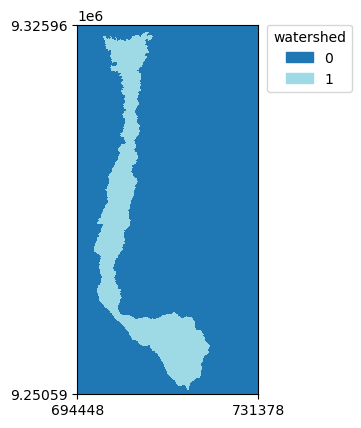

In [37]:
watershed = readmap("ciliwung_catchment.map")
plot(watershed)

<center><img src="Images/ciliwung.png" width="500"/></center>

<div align="center"><i>The result of the Ciliwung watershed delineation using PCRaster is exported into a map. Source: Author.</i></div>